# Data Mining & Machine Learning - Regression Part 2

### Case 2: Prediction of Footballer Values with Supervised Learning

83109 Samuel Didovic<br>
86368 Isabel Lober<br>
85915 Pascal Seitz<br>

Lecturer: Prof. Dr. Adrian Moriariu

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [127]:
# Loading the data
filename = "football_cleaned"

# Data folder
data_dir = "football-data"

file_path = f"{data_dir}/{filename}.csv"

# Read the CSV file directly, specifying the delimiter and thousands separator
df = pd.read_csv(file_path, delimiter=',', thousands=',')

In [128]:
# Identifying non-numeric features
non_numeric_features = df.select_dtypes(include=['object', 'category']).columns

print(non_numeric_features)

Index(['player', 'position', 'squad', 'foot', 'league', 'Season',
       'player_year_id', 'nationality_code', 'position_type',
       'specific_position'],
      dtype='object')


In [129]:
df['player_year_id']

0          1_2017
1          2_2017
2          3_2017
3          4_2017
4          5_2017
          ...    
6587    3936_2019
6588    3937_2019
6589    3420_2019
6590    3144_2019
6591    3938_2019
Name: player_year_id, Length: 6592, dtype: object

In [130]:
player_df = df[['year', 'player', 'nationality_code', 'squad', 'player_year_id']]

In [131]:
player_df.set_index('player_year_id', inplace=True)

In [132]:
player_df.head()

,year,player,nationality_code,squad
player_year_id,,,,
1_2017,2017,Burgui,ESP,Alavés
2_2017,2017,Raphaël Varane,FRA,Real Madrid
3_2017,2017,Rubén Duarte,ESP,Alavés
4_2017,2017,Samuel Umtiti,FRA,Barcelona
5_2017,2017,Manu García,ESP,Alavés


In [133]:
# Setting the player_year_id as the index of the DataFrame
df.set_index('player_year_id', inplace=True)

In [134]:
columns_to_drop = ['player', 'birth_year', 'Season', 'value', 'year', 'Attendance', 'position']  # Columns to drop from the dataset 

X = df.drop(columns_to_drop, axis=1)  # Drop target and any non-predictive columns
y = df['value']  # Target variable

## 1: Pipeline <a name = "first"></a>

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import make_column_selector

def create_preprocessing_pipeline():
    """
    Creates a machine learning pipeline with preprocessing for categorical and numerical data,
    followed by a regression model.

    Returns:
    - pipeline (Pipeline): A complete preprocessing and regression pipeline.
    
    This pipeline includes:
    - OneHotEncoder for categorical features: Handles categorical variables by converting them into a one-hot numeric array.
    - StandardScaler for numerical features: Scales numerical variables to have zero mean and unit variance.
    - GradientBoostingRegressor as the regression model: A powerful ensemble model that uses boosting to build an optimized regression model.
    """
    # Create transformers for categorical and numerical data
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown="ignore"))
    ])

    numerical_transformer = Pipeline([
        ('scaler', StandardScaler())  # Standardizing numerical features
    ])

    # Define the pipeline with proper column selectors
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, make_column_selector(dtype_include=np.number)),  # Automatically selects numerical columns
                ('cat', categorical_transformer, make_column_selector(dtype_include=['object', 'category']))  # Automatically selects categorical columns
            ], remainder='passthrough')),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])

    return pipeline


In [10]:
import json

from skopt.space import Real, Integer
from skopt import BayesSearchCV

def perform_bayesian_optimization(pipeline, X_train, y_train, param_space, n_iter=32, cv=3, scoring='neg_mean_squared_error'):
    """
    Perform Bayesian optimization to find the best hyperparameters for the given pipeline.

    Parameters:
    - pipeline: A scikit-learn Pipeline object.
    - X_train: Training feature data.
    - y_train: Training target data.
    - param_space: Dictionary defining the hyperparameter search space.
    - n_iter: Number of iterations for the Bayesian search.
    - cv: Cross-validation splitting strategy.
    - scoring: Strategy to evaluate the performance of the cross-validated model on the train data.

    Returns:
    - best_params: Dictionary of the best parameters found.
    - opt: BayesSearchCV object after fitting (optional).
    """

    # Create the BayesSearchCV object
    opt = BayesSearchCV(pipeline, param_space, n_iter=n_iter, scoring=scoring, cv=cv, n_jobs=-1, verbose=1)

    # Fit the model
    opt.fit(X_train, y_train)

    return opt.best_params_, opt

def write_optimization_results_to_file(best_params, best_score, suffix='default.txt'):
    """
    Writes the best parameters and the best score from a model optimization process to a text file in a readable format.

    Parameters:
    - best_params: A dictionary containing the best parameters found during the optimization.
    - best_score: The best score achieved during the optimization.
    - suffix: A string to append to the file name to differentiate between different optimization results.
    """
    # Convert the best_params to a string - in a human-readable format using json.dumps
    params_str = json.dumps(best_params, indent=4)
    
    # Write the best parameters and other details to a text file
    file_name = "optimization_results_" + suffix
    with open(file_name, 'w') as file:
        file.write("Best Parameters:\n")
        file.write(params_str + "\n")
        
        # Write the best score if needed
        file.write(f"Best Score (Negative MSE): {best_score}\n")
    
    # Print confirmation that the file has been written
    print(f"Optimization results have been written to '{file_name}'.")


# Example of how to define the parameter space externally:
# param_space = {
#     'regressor__n_estimators': Integer(50, 500),
#     'regressor__max_depth': Integer(3, 10),
#     'regressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
#     'regressor__min_samples_split': Integer(2, 10),
#     'regressor__min_samples_leaf': Integer(1, 10)
# }


## 2: Testing different Splitting methods <a name = "second"></a>

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

def prepare_and_scale_data(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training and testing sets and scales the target variable.

    Parameters:
    - X (DataFrame or array): Features dataset.
    - y (Series or array): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train_scaled, y_test_scaled: Training and testing sets with scaled target variable.
    - scaler: StandardScaler object fitted to the training data.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform it
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # Transform the test data using the same scaler
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train, X_test, y_train_scaled, y_test_scaled, scaler

def prepare_and_scale_data_stratified(X, y, test_size=0.2, random_state=42, bins=10):
    """
    Splits data into training and testing sets using a stratified approach based on the target variable and scales the target variable.

    Parameters:
    - X (DataFrame or array): Features dataset.
    - y (Series or array): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.
    - bins (int): Number of bins to use for stratifying the target variable (stratification strategy for continuous data).

    Returns:
    - X_train, X_test, y_train_scaled, y_test_scaled: Training and testing sets with scaled target variable.
    - scaler: StandardScaler object fitted to the training data.
    
    The function categorizes the continuous target into discrete bins for stratification and then applies standard scaling to the target.
    """
    # Discretize the target variable to enable stratified split
    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Split the data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y_binned
    )

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform it
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # Transform the test data using the same scaler
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train, X_test, y_train_scaled, y_test_scaled, scaler

def evaluate_regression_model(y_train, y_train_pred, y_test, y_test_pred):
    """
    Evaluates the performance of a regression model by calculating and displaying
    several common metrics in a formatted table.
    
    Parameters:
    - y_train (array-like): Actual target values for the training set.
    - y_train_pred (array-like): Predicted target values for the training set.
    - y_test (array-like): Actual target values for the test set.
    - y_test_pred (array-like): Predicted target values for the test set.
    
    Returns:
    - A dictionary containing the calculated metrics for both the training and testing sets.
    """
    
    # Calculate the metrics
    metrics = {
        "Mean Squared Error (MSE)": [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
        "Mean Absolute Error (MAE)": [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
        "Root Mean Squared Error (RMSE)": [np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))],
        "R-squared": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]
    }
    
    # Prepare the data for tabulation
    table = [["Metric", "Train", "Test"]]
    for metric, values in metrics.items():
        table.append([metric, f"{values[0]:.2f}", f"{values[1]:.2f}"])
    
    # Print the table
    print(tabulate(table, headers="firstrow", tablefmt="github"))

    return metrics

def calculate_error_metrics_per_group(y_true, y_pred, num_groups):
    """
    Calculate and display both mean squared error (MSE) and normalized mean squared error (NMSE)
    per predefined value range group for actual target values, formatted as a table using the tabulate library.

    Parameters:
    - y_true (array-like): Actual target values, representing the ground truth for predictions.
    - y_pred (array-like): Predicted values corresponding to y_true.
    - num_groups (int): Number of equal-width intervals to divide the range of actual values into.

    Returns:
    - pandas.DataFrame: DataFrame containing count of samples, range start, range end, MSE, and NMSE for each group.

    This function provides a clear visual insight into model performance across different segments of target variable ranges by
    calculating both absolute and relative error metrics.
    """
    # Create DataFrame to hold actual and predicted values and calculate squared errors
    data = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
    data['SquaredError'] = (data['Actual'] - data['Predicted']) ** 2

    # Determine the range for binning and create bins
    min_val, max_val = data['Actual'].min(), data['Actual'].max()
    bins = np.linspace(min_val, max_val, num_groups + 1)
    data['Group'] = pd.cut(data['Actual'], bins=bins, include_lowest=True, labels=range(1, num_groups + 1))

    # Aggregate data by group for MSE and calculate NMSE within the same grouping
    group_data = data.groupby('Group').agg({
        'Actual': ['count', 'min', 'max'],
        'SquaredError': ['mean', lambda x: x.mean() / np.var(data['Actual']) if np.var(data['Actual']) != 0 else float('inf')]
    })
    group_data.columns = ['Count', 'Range Start', 'Range End', 'MSE', 'NMSE']  # Flatten and rename columns for clarity

    # Format and print the table with tabulate
    print(tabulate(group_data.reset_index(), headers='keys', tablefmt='pretty'))

    return group_data


def calculate_proportional_errors(y_true, y_pred):
    """
    Calculate proportional errors including Mean Absolute Percentage Error (MAPE) and 
    Normalized Mean Squared Error (NMSE).

    Parameters:
    - y_true (array-like): Actual target values. These should be non-zero for MAPE calculation to avoid division by zero.
    - y_pred (array-like): Predicted target values corresponding to y_true.

    Returns:
    - dict: Dictionary containing MAPE and NMSE values.

    This function computes errors that account for the scale of the data, providing a relative measure of the prediction errors.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Calculate MAPE:
    # MAPE is the mean absolute percentage error per data point; it provides an idea of error in terms of the percentage of the actual values.
    # Multiply by 100 to express it as a percentage.
    # Use absolute value to ensure all errors are positive before averaging.
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate NMSE:
    # NMSE normalizes the mean squared error by the variance of the actual values, providing a scale-independent error measure.
    # MSE is the mean of squared differences between actual and predicted values.
    mse = np.mean((y_true - y_pred) ** 2)
    # Variance of y_true is used as the normalizing factor; if variance is zero (all y_true values are the same), NMSE is set to infinity.
    nmse = mse / np.var(y_true) if np.var(y_true) != 0 else float('inf')

    # Return a dictionary with the calculated errors
    return {'MAPE': mape, 'NMSE': nmse}

def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, suffix=""):
    """
    Plots the actual vs. predicted values for training and testing datasets.

    Parameters:
    - y_train: Actual values from the training set.
    - y_train_pred: Predicted values for the training set.
    - y_test: Actual values from the testing set.
    - y_test_pred: Predicted values for the testing set.
    - suffix: An optional suffix to add to the plot title for clarity. Start with a space.
    """

    plt.figure(figsize=(14, 8))  # Set up the figure with a larger size for better visibility
    # Plot training predictions in red
    plt.scatter(y_train, y_train_pred, color='red', alpha=0.5, edgecolor='k', label='Train Predictions')
    # Plot test predictions in blue
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, edgecolor='k', label='Test Predictions')
    # Add a line of perfect prediction
    plt.plot([0, max(y_test.max(), y_train.max())], [0, max(y_test.max(), y_train.max())], 
             color='black', linestyle='--', label='Perfect Prediction')

    # Adding titles and labels
    plt.title(f'Actual vs. Predicted Values:{suffix}', fontsize=20)
    plt.xlabel('Actual Values', fontsize=16)
    plt.ylabel('Predicted Values', fontsize=16)

    # Add a grid for better readability
    plt.grid(True)

    # Add a legend to explain which markers are which
    plt.legend(title="Legend", title_fontsize='13', fontsize='12', loc='upper left')
    plt.tight_layout()
    
    # Format the suffix to be file and title appropriate
    formatted_suffix = suffix.strip().replace(" ", "_").lower()
    
    plt.savefig(f'actual_vs_predicted_{formatted_suffix}.png')
    # Show the plot
    plt.show()

### 2.1 Testing Normal Split <a name = "sub21"></a>

In [185]:
# Prepare and scale the data
X_train, X_test, y_train_scaled, y_test_scaled, normal_scaler = prepare_and_scale_data(X, y)

We already ran a parameter search for the default model (model without special preprocessing or feature engineering). It took:
 to complete

Best Parameters:
{
    
    'regressor__learning_rate', 0.05863911951399646,
    'regressor__max_depth', 5,
    'regressor__min_samples_leaf', 6,
    'regressor__min_samples_split', 3,
    'regressor__n_estimators', 382
}

Best Score (Negative MSE):  
    
    -73902805336975.61


Thats why we will not call the bayesian optimization but rather train the model with the parameters.

In [13]:
# Create the preprocessing pipeline
default_pipeline = create_preprocessing_pipeline()

In [ ]:
# Defining parameter space for the bayesian optimization:
param_space = {
    'regressor__n_estimators': Integer(380, 382),
    'regressor__max_depth': Integer(5, 6),
    'regressor__learning_rate': Real(0.058, 0.059, 'log-uniform'),
    'regressor__min_samples_split': Integer(2, 3),
    'regressor__min_samples_leaf': Integer(6, 7)
}

best_params, opt = perform_bayesian_optimization(default_pipeline, X_train, y_train_scaled, param_space, n_iter=1, cv=3, scoring='neg_mean_squared_error')

In [ ]:
write_optimization_results_to_file(best_params, opt.best_score_)

In [15]:
# Prepare parameters in the form required by scikit-learn estimators
# This typically involves removing any prefixes and adapting parameter names correctly
use_best_params = False
if use_best_params:
    estimator_params = {k.replace("regressor__", ""): v for k, v in best_params.items()}
else:
    # Default parameters
    estimator_params = {
        'n_estimators': 382,
        'max_depth': 5,
        'learning_rate': 0.05863911951399646,
        'min_samples_split': 3,
        'min_samples_leaf': 6
    }

# Update the pipeline regressor with the best parameters
default_pipeline.set_params(regressor__n_estimators=estimator_params['n_estimators'],
                         regressor__learning_rate=estimator_params['learning_rate'],
                         regressor__max_depth=estimator_params['max_depth'],
                         regressor__min_samples_split=estimator_params['min_samples_split'],
                         regressor__min_samples_leaf=estimator_params['min_samples_leaf'])

# Now fitting the pipeline with updated parameters to the scaled training data
default_pipeline.fit(X_train, y_train_scaled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000180F6096390>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000180F6096290>)])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05863911951399646,
                                           max_depth=5, min_samples_leaf=6,
                                           min_samples_split=3,
                                           n_estimators=382,
                                           random_state=42))])

In [16]:
# predicting the target variable for the test and training data
y_test_pred = default_pipeline.predict(X_test)
y_train_pred = default_pipeline.predict(X_train)

In [17]:
default_eval = evaluate_regression_model(y_train_scaled, y_train_pred, y_test_scaled, y_test_pred)

| Metric                         |   Train |   Test |
|--------------------------------|---------|--------|
| Mean Squared Error (MSE)       |    0.03 |   0.2  |
| Mean Absolute Error (MAE)      |    0.11 |   0.25 |
| Root Mean Squared Error (RMSE) |    0.16 |   0.45 |
| R-squared                      |    0.97 |   0.77 |


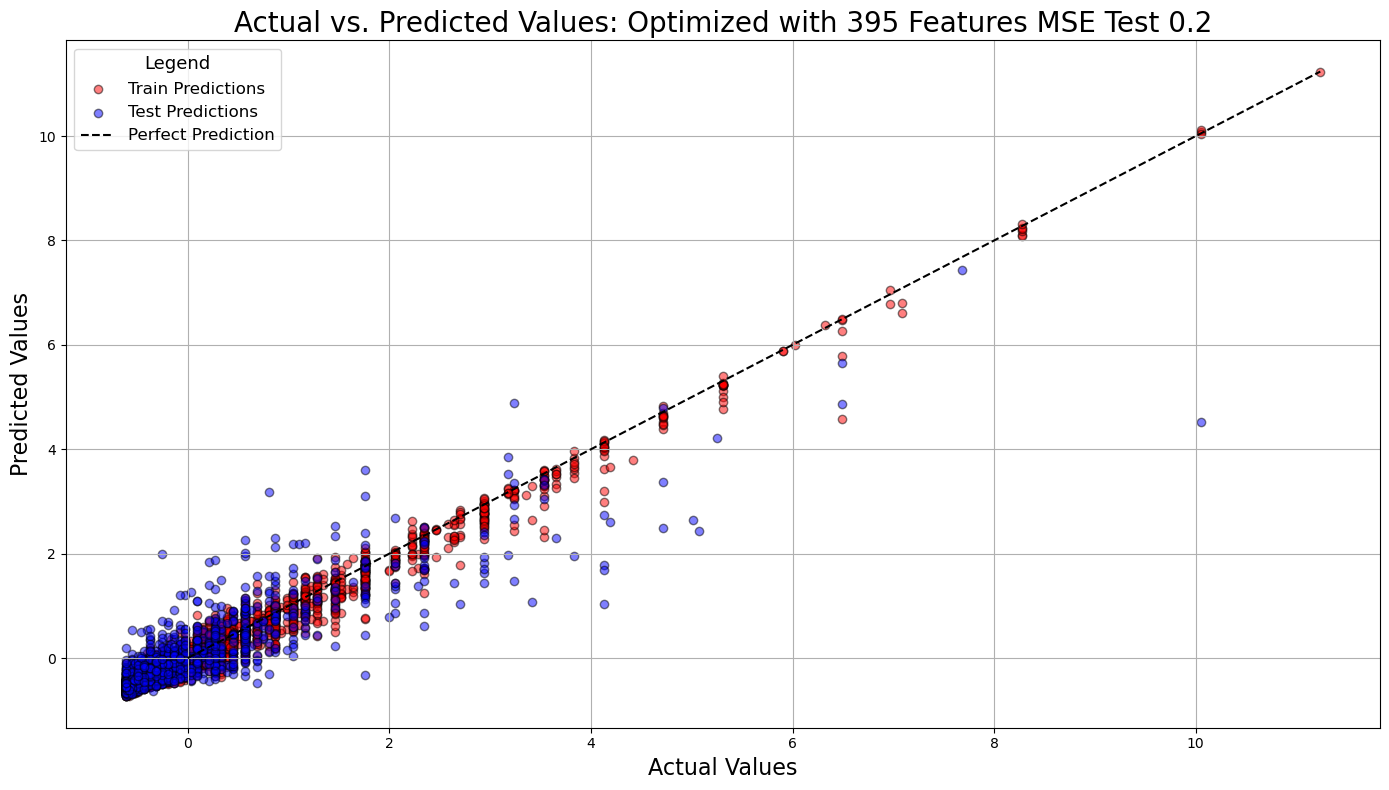

In [80]:
plot_predictions(y_train_scaled, y_train_pred, y_test_scaled, y_test_pred, suffix=f" Optimized with {len(X.columns)} Features MSE Test {np.round(default_eval['Mean Squared Error (MSE)'][1], 2)}")

### 2.2 Testing Stratified Split <a name = "sub22"></a>

In [19]:
stratified_pipeline = create_preprocessing_pipeline()

In [186]:
X_train_stratified, X_test_stratified, y_train_scaled_stratified, y_test_scaled_stratified, stratified_scaler = prepare_and_scale_data_stratified(X, y)

We already ran a parameter search for the default model (model without special preprocessing or feature engineering). It took 80 mins to complete

Best Parameters:
{
    
    'regressor__learning_rate', 0.07025940654568635,
    'regressor__max_depth', 4,
    'regressor__min_samples_leaf', 8,
    'regressor__min_samples_split', 2,
    'regressor__n_estimators', 600
}

Best Score (Negative MSE):  
    
    -0.24398780453548063




In [21]:
# Prepare parameters in the form required by scikit-learn estimators
# This typically involves removing any prefixes and adapting parameter names correctly
use_best_params = False
if use_best_params:
    estimator_params = {k.replace("regressor__", ""): v for k, v in best_params.items()}
else:
    # Default parameters
    estimator_params = {
        'n_estimators': 700,
        'max_depth': 4,
        'learning_rate': 0.07025940654568635,
        'min_samples_split': 2,
        'min_samples_leaf': 8
    }

# Update the pipeline regressor with the best parameters
stratified_pipeline.set_params(regressor__n_estimators=estimator_params['n_estimators'],
                         regressor__learning_rate=estimator_params['learning_rate'],
                         regressor__max_depth=estimator_params['max_depth'],
                         regressor__min_samples_split=estimator_params['min_samples_split'],
                         regressor__min_samples_leaf=estimator_params['min_samples_leaf'])

# Now fitting the pipeline with updated parameters to the scaled training data
stratified_pipeline.fit(X_train_stratified, y_train_scaled_stratified)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000180F9227450>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000180F8ACF210>)])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.07025940654568635,
                                           max_depth=4, min_samples_leaf=8,
                                           n_estimators=700,
                                           random_state=42))])

In [22]:
# predicting the target variable for the test and training data
y_test_stratified_pred = stratified_pipeline.predict(X_test_stratified)
y_train_stratified_pred = stratified_pipeline.predict(X_train_stratified)

In [23]:
stratified_eval = evaluate_regression_model(y_train_scaled_stratified, y_train_stratified_pred, y_test_scaled_stratified, y_test_stratified_pred)

| Metric                         |   Train |   Test |
|--------------------------------|---------|--------|
| Mean Squared Error (MSE)       |    0.02 |   0.32 |
| Mean Absolute Error (MAE)      |    0.1  |   0.28 |
| Root Mean Squared Error (RMSE) |    0.15 |   0.56 |
| R-squared                      |    0.98 |   0.77 |


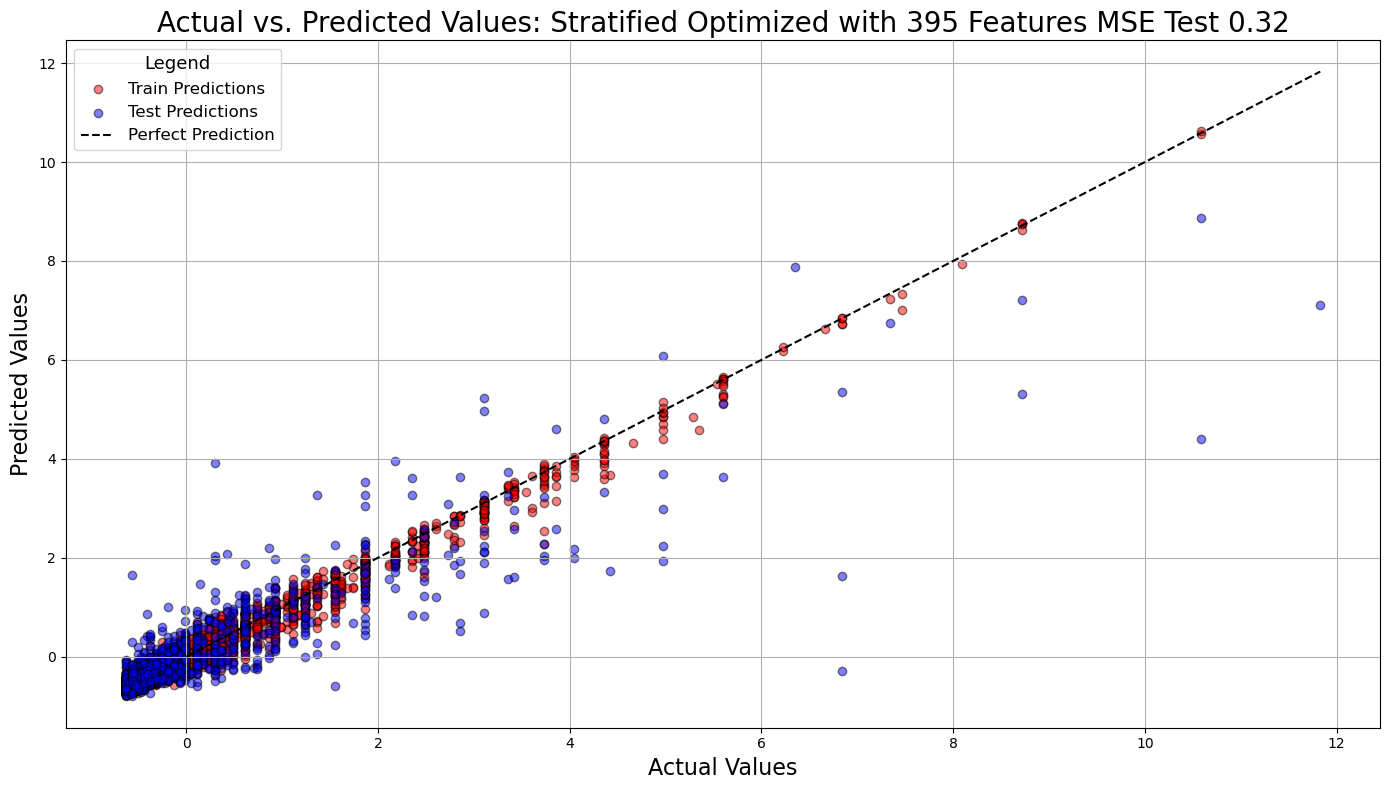

In [81]:
plot_predictions(y_train_scaled_stratified, y_train_stratified_pred, y_test_scaled_stratified, y_test_stratified_pred, suffix=f" Stratified Optimized with {len(X.columns)} Features MSE Test {np.round(stratified_eval['Mean Squared Error (MSE)'][1], 2)}")

### 2.3 Comparison <a name = "sub23"></a>

In [160]:
def extract_feature_importances(model, model_name):
    """
    Extracts and prints the feature importances from a fitted pipeline model that includes a preprocessor and a regressor.
    
    Parameters:
    - model: The fitted pipeline model from which to extract feature importances.
    - model_name: A string indicating the name of the model, used for printing purposes.
    
    Returns:
    - A DataFrame containing the feature names and their corresponding importances, sorted by importance.
    """
    # Extract feature importances from the regressor within the pipeline
    feature_importances = model.named_steps['regressor'].feature_importances_

    # Access the preprocessor step in the pipeline
    preprocessor = model.named_steps['preprocessor']

    # Initialize an empty list to store feature names
    feature_names = []

    # Iterate over all transformers within the ColumnTransformer
    for transformer_name, transformer, columns in preprocessor.transformers_:
        if transformer_name == 'remainder':
            # Process remainder which could be 'passthrough' or another transformer
            if transformer == 'passthrough':
                # If 'passthrough', the original feature names in these columns are added
                feature_names.extend(columns)
        else:
            # Check if transformer has named steps (for nested pipelines), and access the final step
            if hasattr(transformer, 'named_steps'):
                transformer = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            
            # For transformers with the method 'get_feature_names_out'
            if hasattr(transformer, 'get_feature_names_out'):
                # Handle columns selected by slices or explicitly
                if isinstance(columns, slice):
                    transformer_feature_names = transformer.get_feature_names_out(preprocessor.feature_names_in_[columns])
                else:
                    transformer_feature_names = transformer.get_feature_names_out(columns)
                feature_names.extend(transformer_feature_names)
            else:
                # For transformers that do not modify feature names, just add the original names
                feature_names.extend(columns)

    # Create a DataFrame of features and their importance
    features_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Print the top 10 most important features
    print(f"Top 10 Important Features from {model_name}:")
    print(features_importance.head(10))
    
    return features_importance



### Feature Name Extraction Post-Preprocessing

After preprocessing, the original feature names may not correspond directly to the model's input features due to transformations like one-hot encoding, which expands categorical features into multiple binary features. Here's how to handle this in your pipeline:

#### Access the ColumnTransformer
- **Retrieve the ColumnTransformer**: This component contains all transformers applied to subsets of features, both numerical and categorical.

#### Iterate Over Transformers
- **Loop through each transformer** within the ColumnTransformer. These apply specific transformations to selected columns. For transformers like `OneHotEncoder` that alter the number of features, it's essential to retrieve the new feature names.

#### Handle OneHotEncoder
- **OneHotEncoder**: For categorical features processed by `OneHotEncoder`, use `get_feature_names_out()` to retrieve the new names, which are formatted as `<feature_name>_<category>` for clarity.

#### StandardScaler and Passthrough
- **StandardScaler**: Features processed remain with their original names, as this transformer does not alter feature identity.
- **Passthrough**: Directly use the original names for any columns set to "passthrough," which are not transformed at all.

These steps ensure that you can accurately map the feature importances output by your model to the appropriate transformed feature names, enhancing the interpretability of your model's predictions.


In [161]:
def plot_feature_importances(features_importance, top_n=50, model_name="default model", color='red'):
    """
    Plots the top N feature importances for a given model.

    Parameters:
    - features_importance: DataFrame containing the features and their importances. 
                           The DataFrame should have columns named 'Feature' and 'Importance'.
    - top_n: The number of top features to display. Default is 50.
    - model_name: A string indicating the name of the model for the plot title. Default is 'default model (XGBoost)'.
    - color: Color of the bars in the barplot. Default is red.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 8))

    # Create a barplot
    sns.barplot(data=features_importance.head(top_n), x='Importance', y='Feature', palette="viridis")

    # Set the title and labels with dynamic model name
    plt.title(f'Top {top_n} Feature Importances of {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    # Set x-ticks
    plt.xticks(np.arange(0, features_importance['Importance'].max() + 0.01, 0.02))

    # Add a grid for better readability
    plt.grid(True)

    # Show the plot
    plt.show()

def compare_feature_importances(df1, df2, model_name1="Model 1", model_name2="Model 2", top_n=10):
    """
    Plots the top N feature importances side-by-side from two different models for comparison.

    Parameters:
    - df1, df2: DataFrames containing the features and their importances for two different models.
                Each DataFrame should have columns named 'Feature' and 'Importance'.
    - model_name1, model_name2: Strings indicating the names of the models.
    - top_n: The number of top features to display. Default is 10.
    """
    # Prepare the data
    df1 = df1.sort_values(by='Importance', ascending=False).head(top_n)
    df2 = df2.sort_values(by='Importance', ascending=False).head(top_n)
    
    df1['Model'] = model_name1
    df2['Model'] = model_name2

    # Combine the dataframes
    combined_df = pd.concat([df1, df2])
    # Create a catplot
    g = sns.catplot(x="Importance", y="Feature", hue="Model", data=combined_df,
                    kind="bar", height=8, aspect=1.5, palette="viridis", dodge=True)
    
    g.set_axis_labels("Importance", "Features")
    g.fig.suptitle('Top Feature Importances Comparison', fontsize=16)
    g.fig.subplots_adjust(top=0.92)  # Adjust the title to not overlap with plots
    g.add_legend(title="Model")

    # Show the plot
    plt.show()
    

def compare_model_performance(models):
    """
    Generates a figure with four plots to compare two models based on their predictions and feature importances.

    Parameters:
    - models (dict): Dictionary containing data for each model. Each key in the dictionary is a model name,
                     and the value is another dictionary with keys 'y_train', 'y_train_pred', 'y_test', 'y_test_pred', 
                     'features_importance', and optional 'top_n' and 'color' for feature importance plotting.
    """
    
    #models = {
    # "Model 1": {
    #     "y_train": y_train,
    #     "y_train_pred": y_train_pred_model1,
    #     "y_test": y_test,
    #     "y_test_pred": y_test_pred_model1,
    #     "features_importance": features_importance_model1
    # },
    # "Model 2": {
    #     "y_train": y_train,
    #     "y_train_pred": y_train_pred_model2,
    #     "y_test": y_test,
    #     "y_test_pred": y_test_pred_model2,
    #     "features_importance": features_importance_model2
    # }
    # }

    plt.figure(figsize=(28, 16))  # Overall figure size
    
    # Enumerate through models and plot each
    for i, (model_name, model_data) in enumerate(models.items(), 1):
        # Prediction Plot
        plt.subplot(2, 2, i)
        plt.scatter(model_data['y_train'], model_data['y_train_pred'], color='red', alpha=0.5, edgecolor='k', label='Train Predictions')
        plt.scatter(model_data['y_test'], model_data['y_test_pred'], color='blue', alpha=0.5, edgecolor='k', label='Test Predictions')
        plt.plot([0, max(model_data['y_test'].max(), model_data['y_train'].max())], [0, max(model_data['y_test'].max(), model_data['y_train'].max())], 
                 color='black', linestyle='--', label='Perfect Prediction')
        plt.title(f'Actual vs. Predicted Values: {model_name}', fontsize=20)
        plt.xlabel('Actual Values', fontsize=16)
        plt.ylabel('Predicted Values', fontsize=16)
        plt.legend(title="Legend", title_fontsize='13', fontsize='12', loc='upper left')
        plt.grid(True)

        # Feature Importance Plot
        plt.subplot(2, 2, i + 2)
        top_n = model_data.get('top_n', 50)  # Default top_n to 50 if not provided
        color = model_data.get('color', 'red')  # Default color to red if not provided
        sns.barplot(data=model_data['features_importance'].head(top_n), x='Importance', y='Feature', color=color)
        plt.title(f'Top {top_n} Feature Importances of {model_name}', fontsize=20)
        plt.xlabel('Importance', fontsize=16)
        plt.ylabel('Features', fontsize=16)
        plt.xticks(np.arange(0, model_data['features_importance']['Importance'].max() + 0.01, 0.02))
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
def compare_model_predictions(models):
    """
    Generates a flexible number of plots to compare the prediction accuracy of models 
    based on their training and testing datasets. The number of plots is determined by the number of models provided.

    Parameters:
    - models (dict): Dictionary containing data for each model. Each key in the dictionary is a model name,
                     and the value is another dictionary with keys 'y_train', 'y_train_pred', 'y_test', 'y_test_pred'.

    This method plots actual vs. predicted values for both the training and testing data for each model,
    facilitating direct visual comparison between models.
    """

    num_models = len(models)
    if num_models <= 2:
        subplot_dim = (1, num_models)  # Single row for 1 or 2 models
    else:
        subplot_dim = (2, 2)  # 2x2 grid for up to 4 models

    plt.figure(figsize=(10 * subplot_dim[1], 8 * subplot_dim[0]))  # Adjust size based on number of subplots

    # Iterate through the models and plot their predictions
    for i, (model_name, data) in enumerate(models.items(), start=1):
        plt.subplot(subplot_dim[0], subplot_dim[1], i)  # Position each model in its appropriate subplot
        plt.scatter(data['y_train'], data['y_train_pred'], color='red', alpha=0.5, edgecolor='k', label='Train Predictions')
        plt.scatter(data['y_test'], data['y_test_pred'], color='blue', alpha=0.5, edgecolor='k', label='Test Predictions')
        max_val = max(data['y_train'].max(), data['y_test'].max(), data['y_train_pred'].max(), data['y_test_pred'].max())
        plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect Fit')
        plt.title(f'{model_name} - Actual vs. Predicted', fontsize=16)
        plt.xlabel('Actual Values', fontsize=14)
        plt.ylabel('Predicted Values', fontsize=14)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

In [34]:
print("----------------- Default Model -----------------")
default_features_importance = extract_feature_importances(default_pipeline, "Gradient Boosting")

print("\n")
print("-------------- Stratified Model --------------")
stratified_features_importance = extract_feature_importances(stratified_pipeline, "Random Forest")

----------------- Default Model -----------------
Top 10 Important Features from Gradient Boosting:
                   Feature  Importance
379                    Pts    0.109924
26         shots_on_target    0.108022
131           pass_targets    0.069909
0                      age    0.065742
373                      W    0.053142
385                     CL    0.052949
126  players_dribbled_past    0.034174
5                    goals    0.024119
524  league_Premier League    0.023579
47   passes_completed_long    0.021982


-------------- Stratified Model --------------
Top 10 Important Features from Random Forest:
                   Feature  Importance
131           pass_targets    0.127369
379                    Pts    0.118563
0                      age    0.078173
373                      W    0.042793
121   touches_att_pen_area    0.039967
378                  GDiff    0.038947
108      pressures_att_3rd    0.032197
86                     gca    0.028476
3             games_start

In [51]:
# Calculate mean squared error per group
num_groups = 10  # Example to create 5 groups based on the range of values

print("--------------------------------------------- Normal Data Split ----------------------------------------------")
xgb_grouped_mse = calculate_error_metrics_per_group(y_test_scaled.ravel(), y_test_pred, num_groups)

--------------------------------------------- Normal Data Split ----------------------------------------------
+---+-------+--------+---------------------+--------------------+----------------------+---------------------+
|   | Group | Count  |     Range Start     |     Range End      |         MSE          |        NMSE         |
+---+-------+--------+---------------------+--------------------+----------------------+---------------------+
| 0 |  1.0  | 1120.0 | -0.6143808548072252 | 0.4520791686093072 |  0.0729533339542749  | 0.08223054130919312 |
| 1 |  2.0  | 123.0  | 0.5705753850790134  |  1.45929700860181  | 0.39396802799854785  | 0.4440674941756736  |
| 2 |  3.0  |  38.0  | 1.6370413333063691  | 2.348018632124606  |  0.7333433999662993  | 0.8265999848964991  |
| 3 |  4.0  |  22.0  | 2.6442591732988716  | 3.6514770132913745 |  1.295622108456298   | 1.4603816102125724  |
| 4 |  5.0  |  9.0   |  3.829221337995934  |  4.71794296151873  |  3.9655408537525085  | 4.4698241096448275  |
|

In [52]:
print("-------------------------------------------- Stratified Data Split -------------------------------------------")
xgb_grouped_mse = calculate_error_metrics_per_group(y_test_scaled_stratified.ravel(), y_test_stratified_pred, num_groups)

-------------------------------------------- Stratified Data Split -------------------------------------------
+---+-------+--------+---------------------+--------------------+---------------------+---------------------+
|   | Group | Count  |     Range Start     |     Range End      |         MSE         |        NMSE         |
+---+-------+--------+---------------------+--------------------+---------------------+---------------------+
| 0 |  1.0  | 1140.0 | -0.6317945452469345 | 0.6143847038681912 | 0.08369914128291152 | 0.05962400866339011 |
| 1 |  2.0  | 107.0  |  0.676694600972404  | 1.8605826459524482 | 0.4995124993424678  | 0.35583325147384276 |
| 2 |  3.0  |  38.0  |   2.1098222343693   | 3.106780588036705  | 1.3126374277711512  | 0.9350717840792973  |
| 3 |  4.0  |  16.0  | 3.3560201764535567  | 4.3529785301209625 |  1.679703335955926  | 1.1965552420238357  |
| 4 |  5.0  |  8.0   |  4.415288427225175  | 5.599176472205219  |  4.363887403131257  | 3.1086634383843967  |
| 5 |  6.

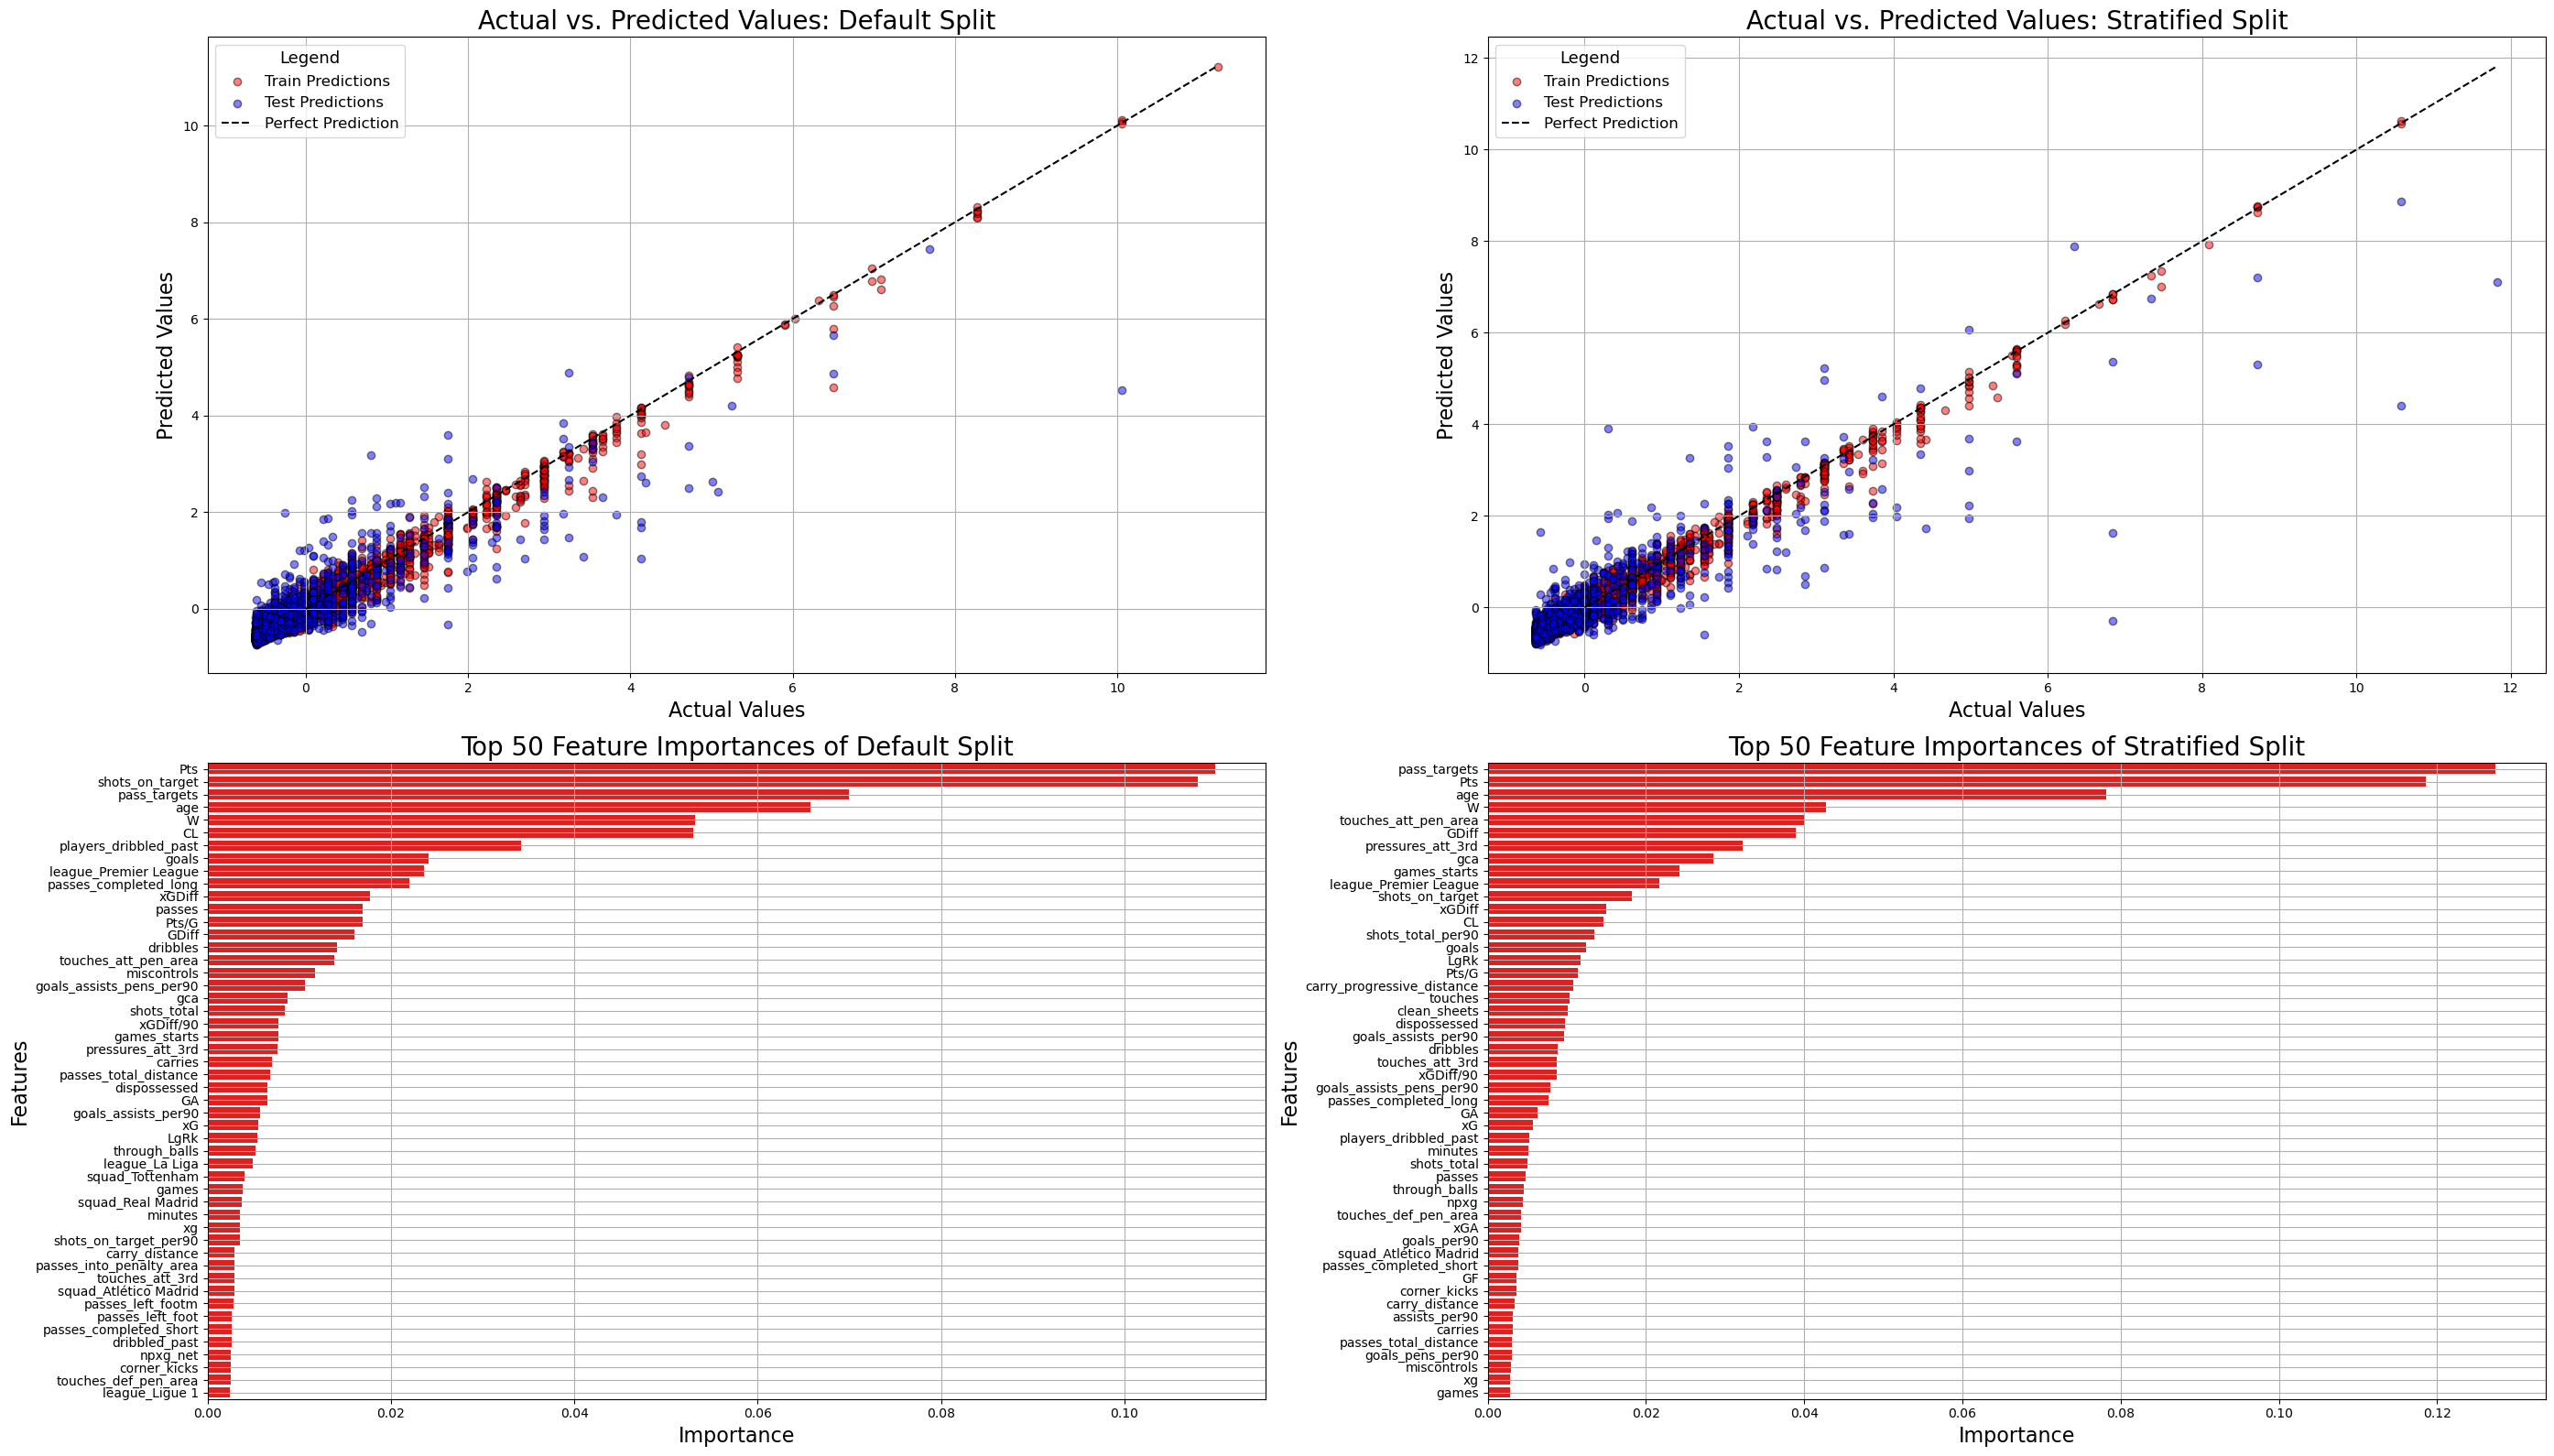

In [83]:
models = {
    "Default Split": {
        "y_train": y_train_scaled,
        "y_train_pred": y_train_pred,
        "y_test": y_test_scaled,
        "y_test_pred": y_test_pred,
        "features_importance": default_features_importance
    },
    "Stratified Split": {
        "y_train": y_train_scaled_stratified,
        "y_train_pred": y_train_stratified_pred,
        "y_test": y_test_scaled_stratified,
        "y_test_pred": y_test_stratified_pred,
        "features_importance": stratified_features_importance
    }
}

compare_model_performance(models)

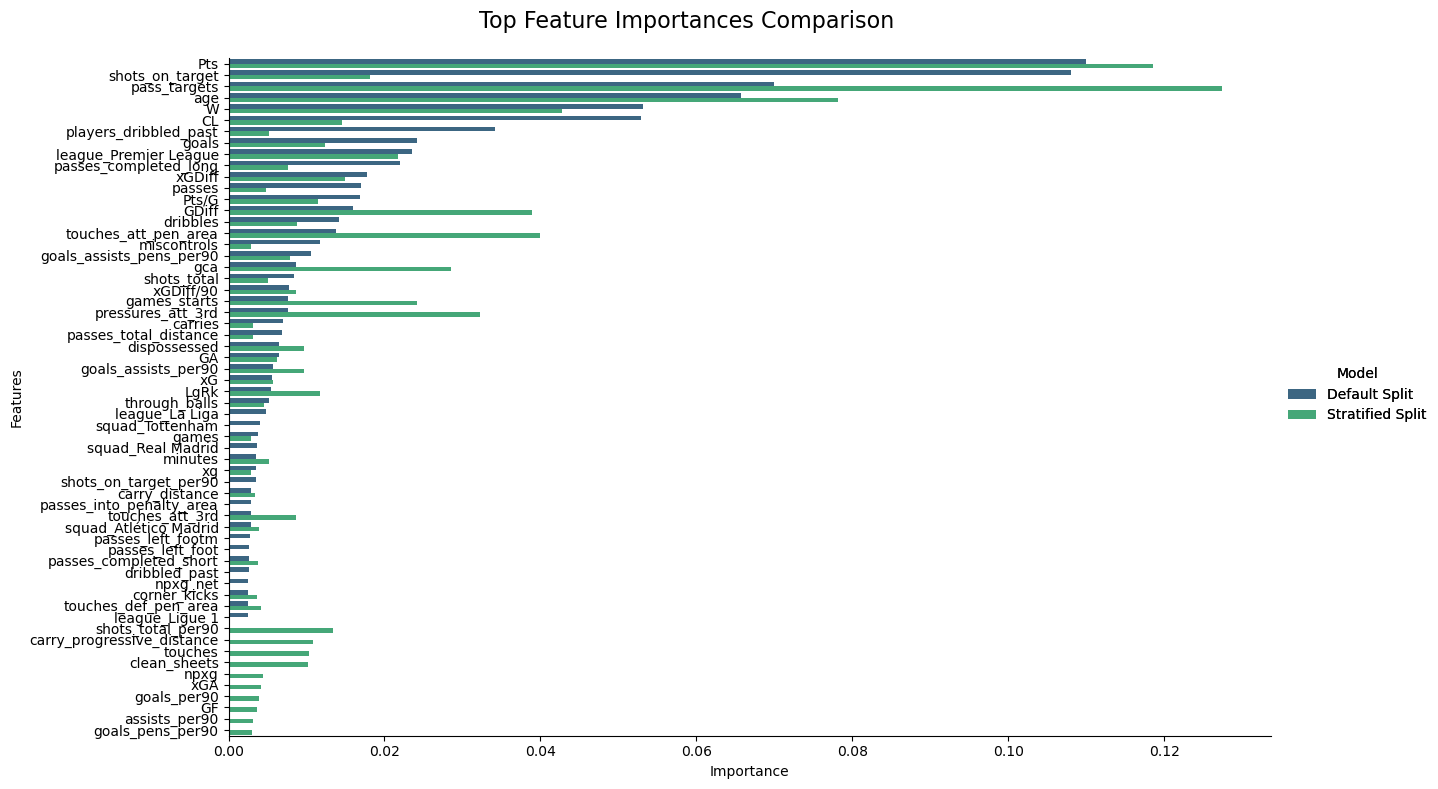

In [50]:
compare_feature_importances(default_features_importance, stratified_features_importance, model_name1="Default Split", model_name2="Stratified Split", top_n=50)

## 3: Removing low importance features <a name = "third"></a>

In [159]:
def remove_unimportant_features(X_train, X_test, features_importance, importance_threshold=0.01):
    """
    Removes features from both training and testing datasets that do not meet the importance threshold. 
    This function ensures that both datasets are treated consistently and only include the important features.

    Parameters:
    - X_train (DataFrame): The training dataset with all features.
    - X_test (DataFrame): The testing dataset with all features.
    - features_importance (DataFrame): A DataFrame containing feature names and their importances.
    - importance_threshold (float): The threshold for determining if a feature is important.

    Returns:
    - X_train_reduced (DataFrame): The training dataset with only the important features retained.
    - X_test_reduced (DataFrame): The testing dataset with only the important features retained.

    This function filters out features whose importance is below a specified threshold according to the provided
    features_importance DataFrame. It ensures that the same features are retained in both training and testing datasets.
    """
    # Ensure the feature names in features_importance are in the columns of X_train
    relevant_importances = features_importance[features_importance['Feature'].isin(X_train.columns)]

    # Filter out features that have an importance less than the threshold
    important_features = relevant_importances[relevant_importances['Importance'] >= importance_threshold]['Feature']

    # Reduce both datasets to only include important features
    X_train_reduced = X_train[important_features.tolist()]
    X_test_reduced = X_test[important_features.tolist()]

    return X_train_reduced, X_test_reduced

In [64]:
# Example usage:
importance_threshold = 0.005 # Define a threshold for feature importance
X_train_stratified_reduced, X_test_stratified_reduced= remove_unimportant_features(X_train_stratified, X_test_stratified, stratified_features_importance, importance_threshold)
print("Reduced dataset shape:", X_train_stratified_reduced.shape, X_test_stratified_reduced.shape)

Reduced dataset shape: (5273, 31) (1319, 31)


In [65]:
reduced_pipeline = create_preprocessing_pipeline()

In [66]:
param_space = {
    'regressor__n_estimators': Integer(200, 1000),
    'regressor__max_depth': Integer(4, 7),
    'regressor__learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'regressor__min_samples_split': Integer(2, 8),
    'regressor__min_samples_leaf': Integer(2, 8)
}

best_params, reduced_obj = perform_bayesian_optimization(reduced_pipeline, X_train_stratified_reduced, y_train_scaled_stratified, param_space, n_iter=64, cv=3, scoring='neg_mean_squared_error')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [67]:
write_optimization_results_to_file(best_params, reduced_obj.best_score_, suffix='reduced_stratified_thresh_0.005.txt')

Optimization results have been written to 'optimization_results_reduced_stratified_thresh_0.005.txt'.


In [70]:
# Predict the target values using the optimized pipeline
y_test_pred_reduced = reduced_obj.predict(X_test_stratified_reduced)
y_train_pred_reduced = reduced_obj.predict(X_train_stratified_reduced)

In [72]:
reduced_eval = evaluate_regression_model(y_train_scaled_stratified, y_train_pred_reduced, y_test_scaled_stratified, y_test_pred_reduced)

| Metric                         |   Train |   Test |
|--------------------------------|---------|--------|
| Mean Squared Error (MSE)       |    0.04 |   0.35 |
| Mean Absolute Error (MAE)      |    0.14 |   0.29 |
| Root Mean Squared Error (RMSE) |    0.21 |   0.59 |
| R-squared                      |    0.96 |   0.75 |


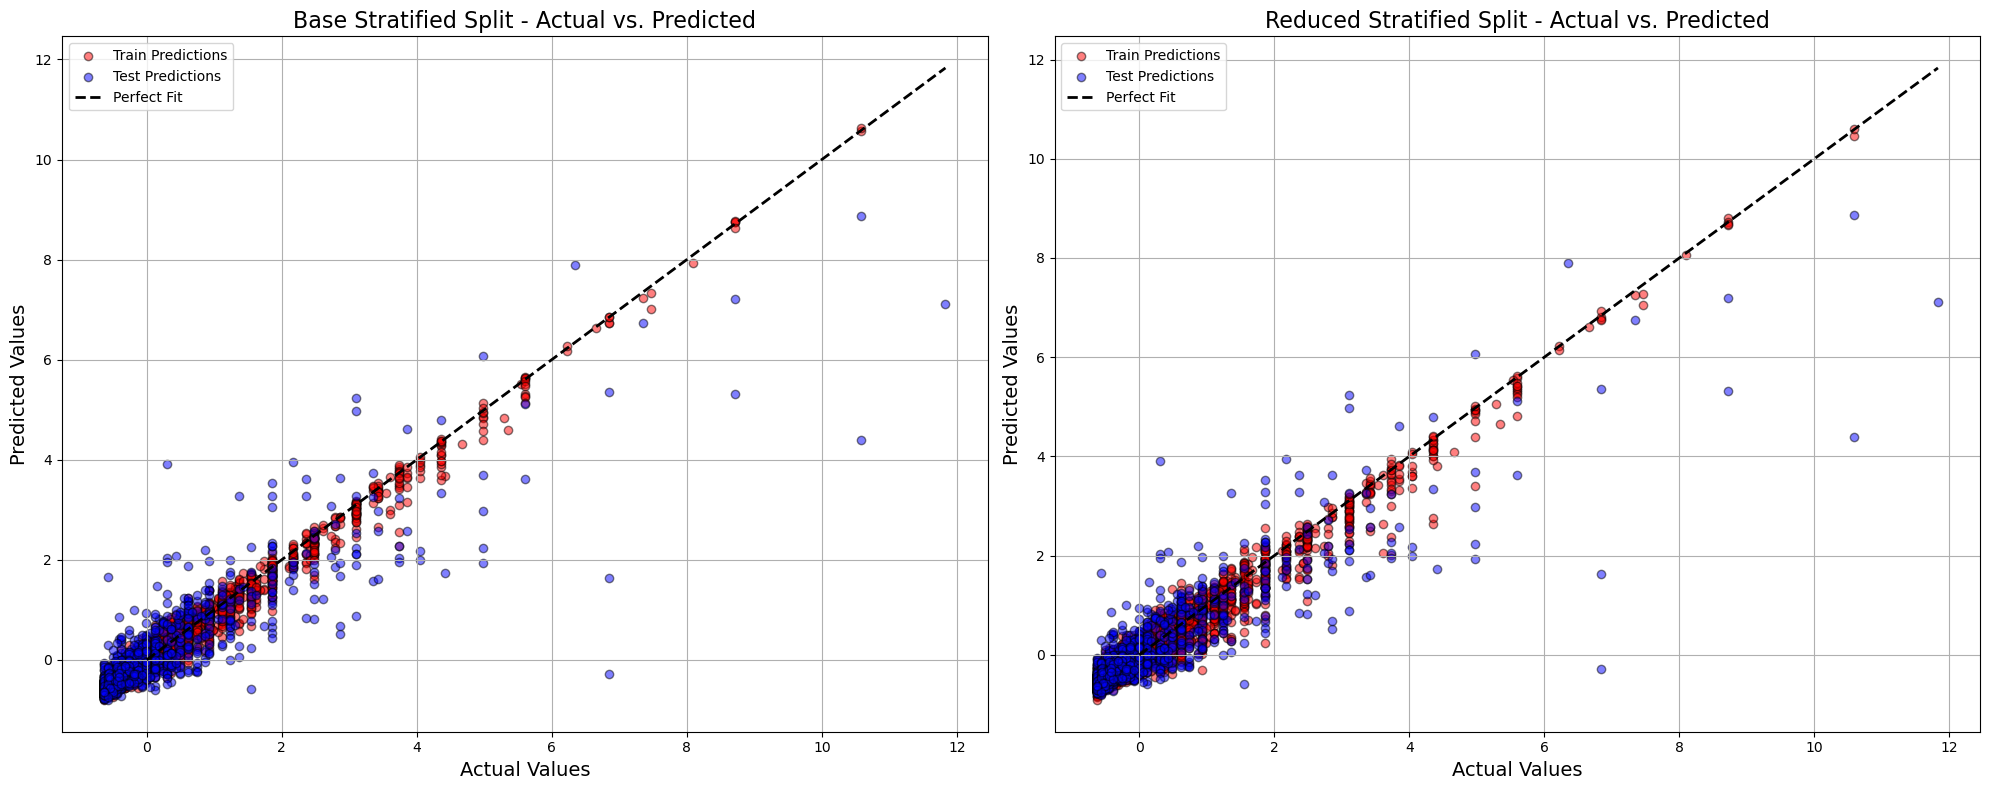

In [162]:
models = {
    "Base Stratified Split": {
        "y_train": y_train_scaled_stratified,
        "y_train_pred": y_train_stratified_pred,
        "y_test": y_test_scaled_stratified,
        "y_test_pred": y_test_stratified_pred,
    },
    "Reduced Stratified Split": {
        "y_train": y_train_scaled_stratified,
        "y_train_pred": y_train_pred_reduced,
        "y_test": y_test_scaled_stratified,
        "y_test_pred": y_test_stratified_pred,
    }
}

compare_model_predictions(models)

## 4: Analysing high error samples <a name = "fourth"></a>

In [266]:
def calculate_squared_errors(y_true, y_pred):
    """
    Calculate the squared error for each individual sample.

    Parameters:
    - y_true (array-like): An array of actual values. These are the ground truth numerical values.
    - y_pred (array-like): An array of predicted values corresponding to y_true. These values are the outputs of the model.

    Returns:
    - numpy.ndarray: An array containing the squared error for each corresponding pair of actual and predicted values.
    
    This function computes the squared difference between each element of `y_true` and `y_pred`, 
    which is useful for evaluating the performance of regression models on a per-sample basis.
    """
    errors = (y_true - y_pred) ** 2
    return errors

def identify_high_error_samples(y_true, y_pred, X, player_info=None, scaler_obj=None, quantile_value=0.90):
    """
    Identify samples where the prediction error exceeds a specified quantile.
    
    Parameters:
    - y_true (array-like or Series): Actual target values.
    - y_pred (array-like or Series): Predicted values from the model.
    - X (DataFrame): DataFrame containing the features used for prediction. Must be aligned with y_true and y_pred. 
                     Assumes player_id is the index.
    - player_info (DataFrame, optional): DataFrame containing additional information about the samples. If provided,
                                         this information will be included in the output. Assumes player_id is the index.
    - scaler_obj (StandardScaler, optional): A fitted StandardScaler object used to inverse transform the target values.
    - quantile_value (float): The quantile value to use as the threshold for identifying high error samples.

    Returns:
    - high_error_samples (DataFrame): DataFrame containing samples with high errors and optionally merged player info.
    """
    
    squared_error  = calculate_squared_errors(y_true, y_pred)
    
    # If a scaler object is provided, inverse transform the actual and predicted values
    if scaler_obj:
        y_true = scaler_obj.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred = scaler_obj.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate errors
    errors = y_true - y_pred
    percent_error = abs(errors / y_true) * 100
        
    # Create a DataFrame from the actual, predicted values, and errors
    df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': errors,
        'SquaredError': squared_error,
        'PercentError': percent_error
    }, index=X.index)  # Ensure index is carried over from X

    # Merge additional player info if provided
    if player_info is not None:
        df = df.join(player_info, how='left')  # Merging on index 'player_year_id'

    # Determine the quantile for 'biggest errors'
    error_threshold = df['SquaredError'].quantile(quantile_value)

    # Filter samples where error exceeds the quantile threshold
    high_error_samples = df[df['SquaredError'] > error_threshold]

    return high_error_samples

def compare_three_similar_players(df, expensive_threshold, good_threshold=10, bad_threshold=20):
    """
    Selects and compares three similarly valued players:
    - One predicted within a reasonable error range (well-predicted).
    - One underpredicted (undervalued).
    - One overpredicted (overpriced).

    Parameters:
    - df (DataFrame): DataFrame containing player prediction data.
    - expensive_threshold (float): Minimum value to consider a player expensive.
    - good_threshold (float): Maximum percent error for well-predicted.
    - bad_threshold (float): Minimum percent error for poorly-predicted.

    Returns:
    - DataFrame: Contains selected players for comparison.
    """
    # Calculate percentage error
    df['PercentError'] = abs((df['Actual'] - df['Predicted']) / df['Actual']) * 100
    
    # Filter expensive players
    expensive_players = df[df['Actual'] >= expensive_threshold]

    # Select players based on the defined thresholds
    well_predicted = expensive_players[expensive_players['PercentError'] <= good_threshold]
    undervalued = expensive_players[(expensive_players['PercentError'] > good_threshold) & (expensive_players['Predicted'] < expensive_players['Actual'])]
    overpriced = expensive_players[(expensive_players['PercentError'] > bad_threshold) & (expensive_players['Predicted'] > expensive_players['Actual'])]

    # Ensure there's at least one player in each category
    if not well_predicted.empty and not undervalued.empty and not overpriced.empty:
        # You can choose a specific way to select one player from each category, here simply picking the first
        comparison_df = pd.concat([well_predicted.head(1), undervalued.head(1), overpriced.head(1)])
        return comparison_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if any category has no players


In [263]:
error_per_row = calculate_squared_errors(y_test_scaled_stratified.ravel(), y_test_pred_reduced)
high_error_samples = identify_high_error_samples(y_test_scaled_stratified.ravel(), y_test_pred_reduced, X_test_stratified_reduced, player_info=player_df, scaler_obj=stratified_scaler, quantile_value=0.95)

In [261]:
high_error_samples.sort_values(by='SquaredError', ascending=False)

,Actual,Predicted,Error,SquaredError,PercentError,year,player,nationality_code,squad
player_year_id,,,,,,,,,
1379_2017,120000000.0,4.518139e+06,1.154819e+08,51.777564,96.234884,2017,Kylian Mbappé,FRA,Monaco
1379_2017,120000000.0,4.518139e+06,1.154819e+08,51.777564,96.234884,2017,Kylian Mbappé,FRA,Paris S-G
3608_2019,180000000.0,8.555860e+07,9.444140e+07,34.628916,52.467444,2019,Kylian MbappĂ©,FRA,Paris S-G
1379_2018,200000000.0,1.231901e+08,7.680989e+07,22.905953,38.404945,2018,Kylian Mbappé,FRA,Paris S-G
1892_2019,120000000.0,4.448309e+07,7.551691e+07,22.141270,62.930761,2019,Harry Kane,ENG,Tottenham
...,...,...,...,...,...,...,...,...,...
916_2018,38000000.0,1.924689e+07,1.875311e+07,1.365403,49.350299,2018,Douglas Costa,BRA,Juventus
77_2019,7000000.0,2.552802e+07,-1.852802e+07,1.332822,264.685991,2019,Olivier Giroud,FRA,Chelsea
183_2017,5000000.0,2.272487e+07,-1.772487e+07,1.219776,354.497303,2017,Erik Thommy,GER,Augsburg


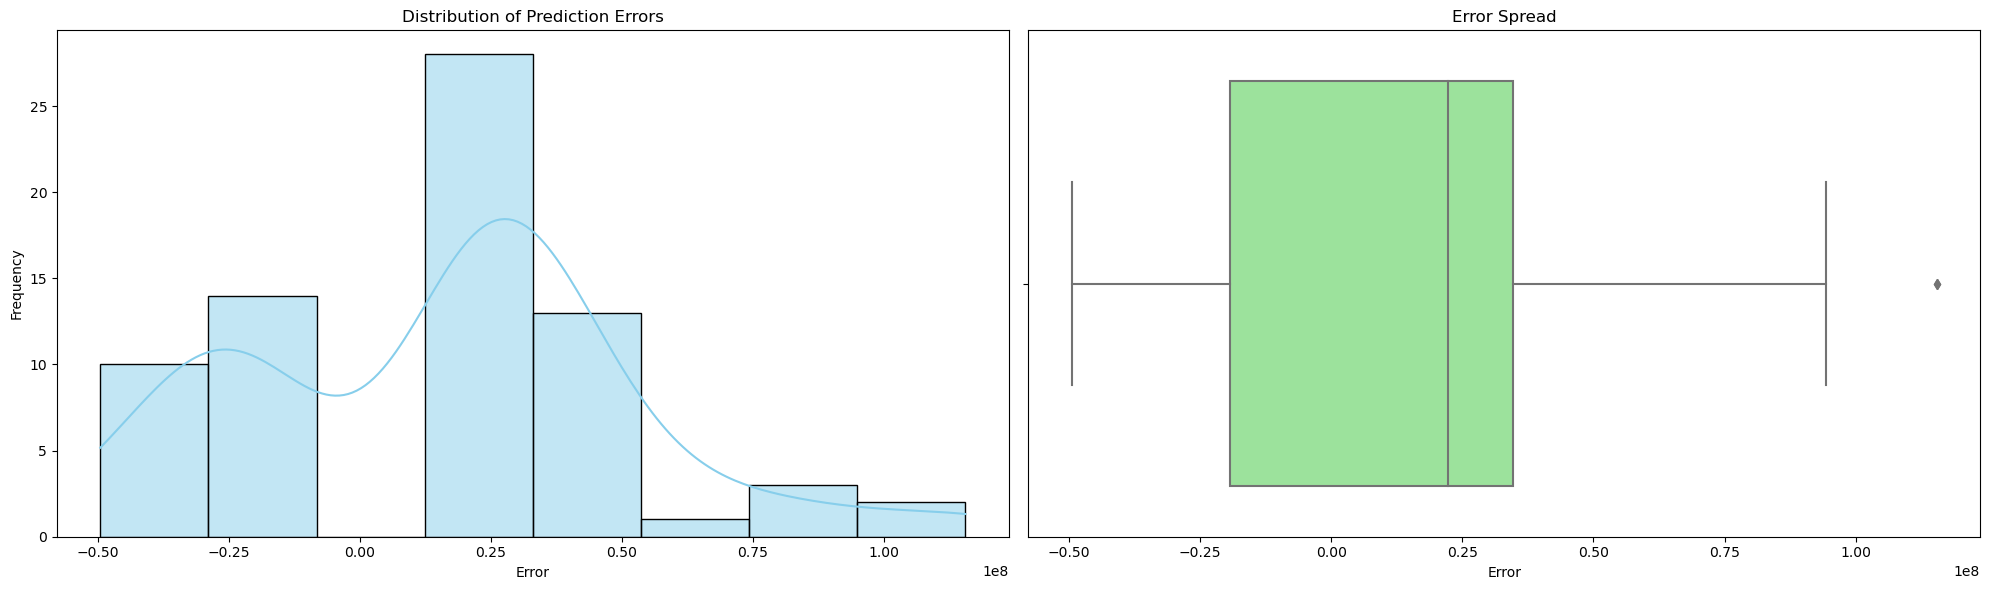

In [251]:
# Setup the matplotlib figure
plt.figure(figsize=(20, 6))

# Create a subplot for the histogram of errors
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(high_error_samples['Error'], kde=True, color='skyblue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')

# Create a subplot for the boxplot of errors
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.boxplot(x=high_error_samples['Error'], color='lightgreen')
plt.title('Error Spread')
plt.xlabel('Error')

# Show the plots
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

In [252]:
def format_large_numbers(x):
    """
    Formats large numbers in a more readable way by scaling them down and appending
    appropriate suffixes ('K' for thousands, 'M' for millions, and 'B' for billions).
    
    Parameters:
    - x (int, float): The number to format. Expected to be an integer or floating-point number.
    
    Returns:
    - str: A formatted string representing the number with a suffix indicating the scale 
           ('K', 'M', 'B') or the original number if it doesn't meet any scale conditions.
           If the number is zero, it returns "0.00" for consistency in decimal places.

    Description:
    - The function checks if the input `x` is an integer or float. If not, it immediately 
      returns the input as is, assuming it's not a number that needs formatting.
    
    - For numeric inputs, the function first takes the absolute value to handle both 
      positive and negative numbers uniformly.
    
    - It then checks the scale of the number:
      - If `x` is 1 billion (1e9) or larger, it divides the number by 1 billion and 
        formats it as a floating-point number with two decimal places, appending 'B' to denote billions.
      - If `x` is 1 million (1e6) or larger (but less than 1 billion), it follows a similar process but 
        divides by 1 million and appends 'M' to denote millions.
      - If `x` is 1 thousand (1e3) or larger (but less than 1 million), it divides by 1 thousand 
        and appends 'K' to denote thousands.
      - If `x` is exactly zero, it formats it as "0.00" to maintain decimal consistency with other formatted numbers.
    
    - If none of these conditions are met (i.e., the number is less than 1,000 but not zero), 
      the function simply returns the number as a string without modification, preserving its original form.
    
    Example Usage:
    - For an input of 1234567890, the output would be '1.23B'.
    - For an input of 234567, the output would be '234.57K'.
    - For an input of 50, the output would be '50' (unchanged because it is less than 1,000).
    """
    if isinstance(x, (int, float)):
        if abs(x) >= 1e9:
            return f"{x/1e9:.2f}B"
        elif abs(x) >= 1e6:
            return f"{x/1e6:.2f}M"
        elif abs(x) >= 1e3:
            return f"{x/1e3:.2f}K"
        elif abs(x) == 0:
            return f"{x:.2f}"
    return x


In [253]:
year = high_error_samples['year']

In [254]:
high_error_samples = high_error_samples.applymap(format_large_numbers)
high_error_samples['year'] = year


In [256]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)
high_error_samples.sort_values(by='SquaredError', ascending=False)


,Actual,Predicted,Error,SquaredError,year,player,nationality_code,squad,NumericError
player_year_id,,,,,,,,,
1379_2017,120.00M,4.52M,115.48M,51.777564,2017,Kylian Mbappé,FRA,Monaco,115.48M
1379_2017,120.00M,4.52M,115.48M,51.777564,2017,Kylian Mbappé,FRA,Paris S-G,115.48M
3608_2019,180.00M,85.56M,94.44M,34.628916,2019,Kylian MbappĂ©,FRA,Paris S-G,94.44M
1379_2018,200.00M,123.19M,76.81M,22.905953,2018,Kylian Mbappé,FRA,Paris S-G,76.81M
1892_2019,120.00M,44.48M,75.52M,22.141270,2019,Harry Kane,ENG,Tottenham,75.52M
1892_2017,150.00M,76.18M,73.82M,21.157966,2017,Harry Kane,ENG,Tottenham,73.82M
72_2017,75.00M,22.76M,52.24M,10.593750,2017,Pierre-Emerick Aubameyang,GAB,Dortmund,52.24M
72_2017,75.00M,22.76M,52.24M,10.593750,2017,Pierre-Emerick Aubameyang,GAB,Arsenal,52.24M
195_2019,112.00M,161.52M,-49.52M,9.519464,2019,Lionel Messi,ARG,Barcelona,-49.52M


In [257]:
pd.reset_option('display.max_rows')

In [268]:
value_range = 5000000  # $60,000,000 range for similarity and prediction categorization

comparison_df = compare_three_similar_players(high_error_samples, value_range)
print(comparison_df)

Empty DataFrame
Columns: []
Index: []
